In [1]:
'''
1. State 정의
2. Node 정의
3. StateGraph 생성
4. 컴파일
5. 시각화
'''

import os
import warnings
from dotenv import load_dotenv

# .env 로드
load_dotenv()
# os.getenv("OPENAI_API_KEY")

# 경고 무시
warnings.filterwarnings("ignore")

# ./cache/ 경로에 다운로드 받도록 설정 (모델 다운로드 받을 경로 지정)
os.environ["HF_HOME"] = "./cache/"


In [2]:
from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
import operator

# State 정의
class GraphState(TypedDict):
    context : Annotated[List[Document], operator.add]
    answer : Annotated[List[Document], operator.add]
    question: Annotated[str, "user question"]
    sql_query: Annotated[str, "sql query"]
    binary_score: Annotated[str, "binary score yes or no"]

In [7]:
# Node 정의
def retrieve(state : GraphState) -> GraphState:
    # 검색
    documents = "검색된 문서"
    return {"context":documents}

def rewrite_query(state : GraphState)->GraphState:
    # 쿼리 재작성
    documents = "검색된 문서"
    return GraphState(context=documents)

def llm_gpt_execute(state:GraphState)->GraphState:
    # LLM 실행
    answer = "GPT 생성된 답변"
    return GraphState(answer=answer)

def llm_gemini_execute(state:GraphState)->GraphState:
    # LLM 실행
    answer = "Gemini 의 생성된 답변"
    return GraphState(answer=answer)

def relevance_check(state:GraphState)->GraphState:
    # 관련성 확인
    binary_score = "Relevance Score"
    return GraphState(binary_score=binary_score)

def sum_up(state:GraphState)->GraphState:
    # 결과 종합
    answer = "종합된 답변"
    return GraphState(answer=answer)

def search_on_web(state:GraphState)->GraphState:
    # 웹 검색
    documents = state["context"] = "기존 문서"
    searched_documents = "검색된 문서"
    documents += searched_documents
    return GraphState(context=documents)

def get_table_info(state: GraphState)->GraphState:
    # 테이블 정보 가져오기
    table_info = "테이블 정보"
    return GraphState(context=table_info)

def generate_sql_query(state:GraphState)->GraphState:
    # SQL 쿼리 생성
    sql_query = "SQL 쿼리"
    return GraphState(sql_query=sql_query)

def execute_sql_query(state:GraphState)->GraphState:
    # SQL 쿼리 실행
    sql_result = "SQL 결과"
    return GraphState(context=sql_result)

def validate_sql_query(state: GraphState) -> GraphState:
    # SQL 쿼리 검증
    binary_score = "SQL 쿼리 검증 결과"
    return GraphState(binary_score=binary_score)

def handle_error(state:GraphState)->GraphState:
    # 에러 처리
    error = "에러 발생"
    return GraphState(context=error)

def decision(state: GraphState)->GraphState:
    # 의사결정
    if state["binary_score"] == "yes":
        return "종료"
    else:
        return "재검색"

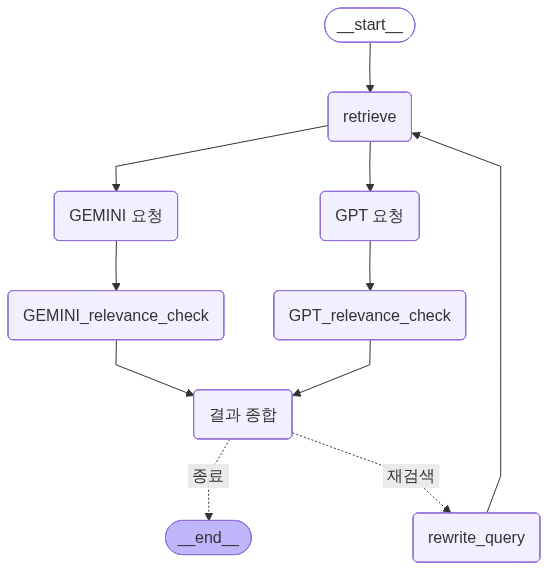

In [11]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image

# (1): Conventional RAG
# (2): 재검색
# (3): 멀티 LLM
# (4): 쿼리 재작성

workflow = StateGraph(GraphState)

# 상태그래프에 node 추가
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite_query", rewrite_query)

workflow.add_node("GPT 요청", llm_gpt_execute)
workflow.add_node("GEMINI 요청", llm_gemini_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("GEMINI_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)

# 노드를 edge 로 연결
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("retrieve", "GPT 요청")
workflow.add_edge("retrieve", "GEMINI 요청")    # 병렬 실행
workflow.add_edge("GPT 요청", "GPT_relevance_check")
workflow.add_edge("GEMINI 요청", "GEMINI_relevance_check")
workflow.add_edge("GPT_relevance_check", "결과 종합")
workflow.add_edge("GEMINI_relevance_check", "결과 종합")
# workflow.add_edge("결과 종합", END)
# 조건부 엣지로 변경
workflow.add_conditional_edges(
    "결과 종합",        # 결과 종합에 조건부엣지
    decision,           # decision 함수의 실행 리턴이 "재검색"이면/"종료"면
    {
        "재검색": "rewrite_query",           # rewrite_query 로 보내냐
        "종료": END                     # 완료하냐
    }
)

# START로 안하고 set_entry_point로 시작점을 지정할 수도 있음
workflow.set_entry_point("retrieve")
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

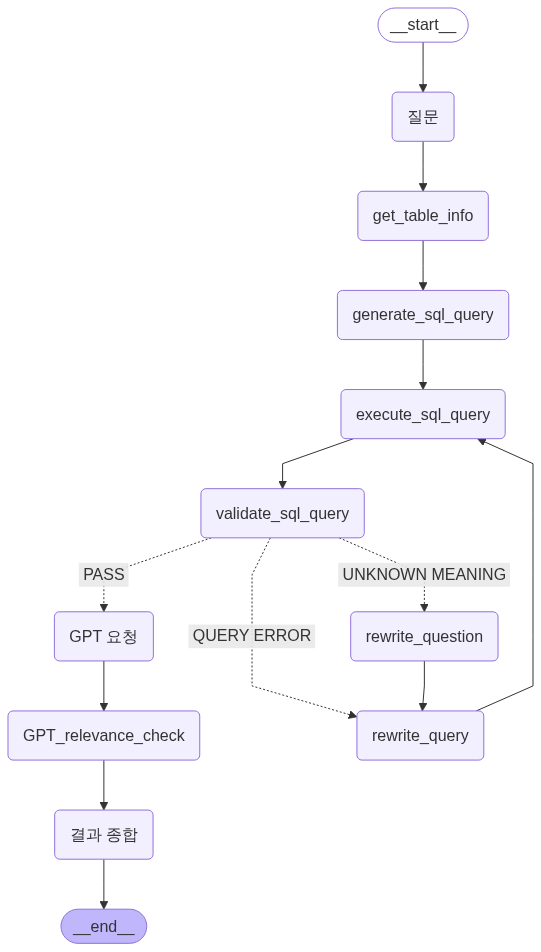

In [13]:
# SQL RAG 예시
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image

# 상태 그래프 만들고
workflow = StateGraph(GraphState)

# 노드 추가하고
workflow.add_node("질문", retrieve)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("rewrite_question", rewrite_query)
workflow.add_node("GPT 요청", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("결과 종합", sum_up)
workflow.add_node("get_table_info", get_table_info)
workflow.add_node("generate_sql_query", generate_sql_query)
workflow.add_node("execute_sql_query", execute_sql_query)
workflow.add_node("validate_sql_query", validate_sql_query)

# 엣지로 연결하고
workflow.add_edge("질문", "get_table_info")
workflow.add_edge("get_table_info", "generate_sql_query")
workflow.add_edge("generate_sql_query", "execute_sql_query")
workflow.add_edge("execute_sql_query", "validate_sql_query")
workflow.add_conditional_edges(
    "validate_sql_query",       # validate_sql_query 마치고 조건부엣지 실행
    decision,           # decision 리턴 결과에 따라 분기
    {
        "QUERY ERROR": "rewrite_query",         # 쿼리에러면 rewrite_query 노드로
        "UNKNOWN MEANING": "rewrite_question",  # 의미불명이면 rewrite_question 노드로
        "PASS": "GPT 요청"                       # 통과면 GPT 요청 노드로
    }
)
workflow.add_edge("rewrite_query", "execute_sql_query")
workflow.add_edge("rewrite_question", "rewrite_query")
workflow.add_edge("GPT 요청", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "결과 종합")
workflow.add_edge("결과 종합", END)
workflow.set_entry_point("질문")

# 컴파일
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

# 시각화
display(Image(app.get_graph().draw_mermaid_png()))